<a href="https://colab.research.google.com/github/keplaxo/fastai-v3xrayclassifier/blob/master/X_RAY_CLASSIFIER_FASTAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *

## Get a list of URLs

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [0]:
folder = 'CHEST'
file = 'urls_chest.txt'

In [0]:
folder = 'FOOT'
file = 'urls_foot.txt'

In [0]:
folder = 'HAND'
file = 'urls_hand.txt'

You will need to run this cell once per each category.

In [0]:
path = Path('data/xrays')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()


[PosixPath('data/xrays/sample_data'),
 PosixPath('data/xrays/urls_chest.txt'),
 PosixPath('data/xrays/FOOT'),
 PosixPath('data/xrays/urls_foot.txt'),
 PosixPath('data/xrays/urls_hand.txt'),
 PosixPath('data/xrays/CHEST'),
 PosixPath('data/xrays/HAND')]

## Download images

Now we download your images from their respective urls.

fast.ai has a function that allows you to do just that. Specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. 

You will need to run this line once for every category.

In [0]:
classes = ['CHEST','FOOT','HAND']

In [0]:
download_images(path/file, dest, max_pics=200)

Error https://www.spirit-zone.com/wp-content/uploads/2018/10/x-ray-analysis-confirms-this-could-really-be-a-mummified-alien-hand.jpg HTTPSConnectionPool(host='www.spirit-zone.com', port=443): Max retries exceeded with url: /wp-content/uploads/2018/10/x-ray-analysis-confirms-this-could-really-be-a-mummified-alien-hand.jpg (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fce849220f0>, 'Connection to www.spirit-zone.com timed out. (connect timeout=4)'))


In [0]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

CHEST


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


FOOT


cannot identify image file <_io.BufferedReader name='data/xrays/FOOT/00000059.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


HAND


cannot identify image file <_io.BufferedReader name='data/xrays/HAND/00000064.jpg'>
cannot identify image file <_io.BufferedReader name='data/xrays/HAND/00000152.jpg'>
cannot identify image file <_io.BufferedReader name='data/xrays/HAND/00000085.jpg'>
cannot identify image file <_io.BufferedReader name='data/xrays/HAND/00000054.jpg'>


## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Let's take a look at some of our pictures then.

In [0]:
data.classes

['CHEST', 'FOOT', 'HAND']

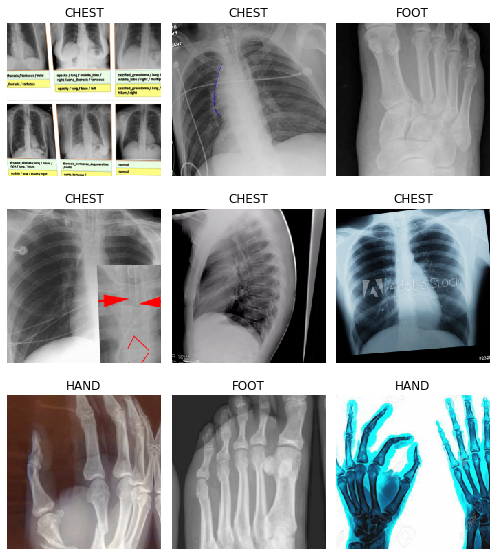

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['CHEST', 'FOOT', 'HAND'], 3, 472, 117)

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 229MB/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.213164,0.542890,0.188034,00:08
1,0.783280,0.548089,0.111111,00:07
2,0.610695,0.515996,0.102564,00:07
3,0.503515,0.510858,0.102564,00:07


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


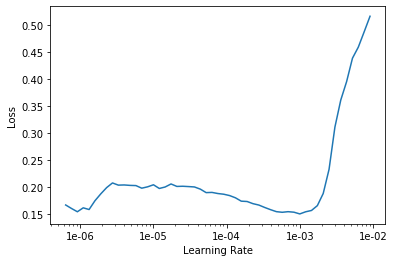

In [0]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.029601,0.371984,0.042735,00:08
1,0.043124,0.362354,0.042735,00:08


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

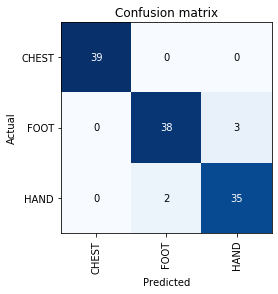

In [0]:
interp.plot_confusion_matrix()

The model is doing quite well but shows apparent diificulty with hand and foot images. With a larger dataset perhaps we can rectfy this in the future. 

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
#defaults.device = torch.device('cpu')

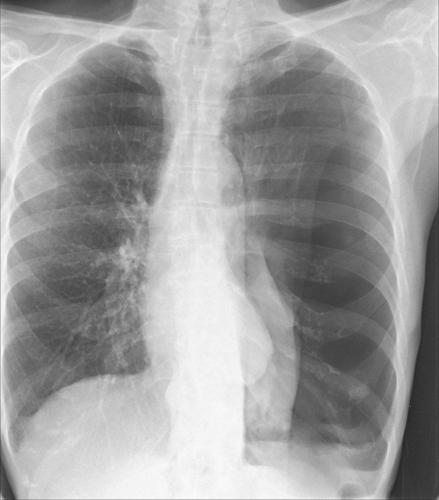

In [0]:
img = open_image(path/'CHEST'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category black

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)